### Housekeeping and Data

# Section 3: Panel data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
import linearmodels.panel as lmp
import pytwoway as tw
import bipartitepandas as bpd
import seaborn as sns
from linearmodels.iv import IV2SLS

%matplotlib inline

We use data from the CHARLS panel survey. Variable description follows:  

- INID: identificador unico
- wave: periodo de la encuesta (1-3)
- cesd: puntaje en la escala de salud mental (0-30)
- child: numero de hijos
- drinkly: bebio alcohol en el ultimo mes (binario)
- hrsusu: horas promedio trabajo semanal
- hsize: tamano del hogar
- intmonth: mes en que fue encuestado/a (1-12)
- married: si esta casado/a (binario)
- retired: si esta pensionado/a (binario)
- schadj: años de escolaridad
- urban: zona urbana (binario)
- wealth: riqueza neta (miles RMB)
- age: edad al entrar a la encuesta (no varia entre periodos)


In [3]:
# example data
charls = pd.read_csv('../data/charls.csv')
charls.dropna(inplace=True)
charls.reset_index(drop=True, inplace=True)

charls.head()

,age,bnrps,cesd,child,dnrps,drinkly,female,hrsusu,hsize,intmonth,married,nrps,retage,retired,schadj,urban,wave,wealth,inid
0,46,0.000000,6.0,2,0,0,1,0.000000,4,7,1,0,24,0,0,0,1,-5800.0,1
1,48,58.964134,7.0,2,1,0,1,3.891820,4,7,1,1,17,0,0,0,2,100.0,1
2,50,60.000130,5.0,2,1,0,1,4.025352,7,8,1,1,10,0,0,0,3,-59970.0,1
3,48,0.000000,0.0,2,0,1,0,4.143135,4,7,1,0,22,0,4,0,1,-5800.0,2
4,50,58.964134,5.0,2,1,1,0,3.891820,4,7,1,1,0,0,4,0,2,100.0,2


In [4]:
#variable construction
charls['wealth']=charls['wealth']/1000
X=charls[['child','hrsusu','hsize','retired','wealth','age']]
Xm=(X.groupby(charls['inid']).transform('mean'))
Xid=charls[['inid','wave','cesd','child','hrsusu','hsize','retired','wealth','age']]
Xc=pd.DataFrame(np.c_[Xid, Xm], columns=['inid','wave','cesd','child','hrsusu','hsize','retired','wealth','age','mchild','mhrsusu','mhsize','mretired','mwealth','mage'])

#set panel structure
Xc = Xc.set_index(["inid","wave"])
Xc.describe()

,cesd,child,hrsusu,hsize,retired,wealth,age,mchild,mhrsusu,mhsize,mretired,mwealth,mage
count,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000,21045.000000
mean,8.656878,2.825232,2.548166,3.585222,0.204942,6.783959,59.386553,2.825232,2.548166,3.585222,0.204942,6.783959,59.386553
std,6.307677,1.372179,1.757182,1.720136,0.403669,54.530651,9.016106,1.315790,1.446015,1.476978,0.338931,44.973909,8.846422
min,0.000000,0.000000,0.000000,1.000000,0.000000,-1648.450000,20.000000,0.000000,0.000000,1.000000,0.000000,-1648.450000,24.000000
25%,4.000000,2.000000,0.000000,2.000000,0.000000,0.100000,52.000000,2.000000,1.476939,2.333333,0.000000,0.200000,52.000000
50%,7.000000,3.000000,3.401197,3.000000,0.000000,1.000000,59.000000,2.666667,2.870106,3.333333,0.000000,1.500000,59.000000
75%,12.000000,4.000000,4.025352,5.000000,0.000000,6.800000,65.000000,3.500000,3.817300,4.500000,0.333333,10.225000,65.000000
max,30.000000,10.000000,5.123964,16.000000,1.000000,1040.000000,95.000000,10.000000,5.123964,15.000000,1.000000,900.100000,95.000000


## Pooled OLS

In [5]:
y=Xc['cesd']
X=Xc[['child','hrsusu','hsize','retired','wealth']]
X=sm.add_constant(X)
model = lmp.PanelOLS(y, X)
mco = model.fit()
print(mco)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   cesd   R-squared:                        0.0203
Estimator:                   PanelOLS   R-squared (Between):              0.0290
No. Observations:               21045   R-squared (Within):              -0.0116
Date:                Thu, Apr 27 2023   R-squared (Overall):              0.0203
Time:                        12:51:43   Log-likelihood                -6.841e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      87.134
Entities:                        9194   P-value                           0.0000
Avg Obs:                       2.2890   Distribution:                 F(5,21039)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             87.134
                            

## First differences

In [7]:
y=Xc['cesd']
X=Xc[['child','hrsusu','hsize','retired','wealth']]
model=lmp.FirstDifferenceOLS(y,X)
fd=model.fit(cov_type="robust")
print(fd)

                     FirstDifferenceOLS Estimation Summary                      
Dep. Variable:                   cesd   R-squared:                        0.0012
Estimator:         FirstDifferenceOLS   R-squared (Between):             -0.1363
No. Observations:               10624   R-squared (Within):               0.0008
Date:                Thu, Apr 27 2023   R-squared (Overall):             -0.1260
Time:                        10:53:37   Log-likelihood                -3.436e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2.5997
Entities:                        9194   P-value                           0.0235
Avg Obs:                       2.2890   Distribution:                 F(5,10619)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             2.5373
                            

## Fixed Effects 

In [8]:
X=Xc[['child','hrsusu','hsize','retired','wealth']]
X=sm.add_constant(X)
model=lmp.PanelOLS(y,X, entity_effects=True)
fe=model.fit(cov_type="robust")
print(fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   cesd   R-squared:                        0.0009
Estimator:                   PanelOLS   R-squared (Between):              0.0051
No. Observations:               21045   R-squared (Within):               0.0009
Date:                Thu, Apr 27 2023   R-squared (Overall):              0.0040
Time:                        10:53:38   Log-likelihood                -5.516e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2.1217
Entities:                        9194   P-value                           0.0598
Avg Obs:                       2.2890   Distribution:                 F(5,11846)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             1.9852
                            

## Random Effects


In [9]:
model=lmp.RandomEffects(y,X)
re=model.fit(cov_type="robust")
print(re)

                        RandomEffects Estimation Summary                        
Dep. Variable:                   cesd   R-squared:                        0.0272
Estimator:              RandomEffects   R-squared (Between):              0.0246
No. Observations:               21045   R-squared (Within):              -0.0037
Date:                Thu, Apr 27 2023   R-squared (Overall):              0.0182
Time:                        10:53:41   Log-likelihood                -6.123e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      117.70
Entities:                        9194   P-value                           0.0000
Avg Obs:                       2.2890   Distribution:                 F(5,21039)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             39.740
                            

In [24]:
re.variance_decomposition

Effects                   19.462592
Residual                  19.636244
Percent due to Effects     0.497779
Name: Variance Decomposition, dtype: float64

## Model comparison

In [10]:
print(lmp.compare({"FE": fe, "RE": re, "Pooled": mco}))

                           Model Comparison                           
                                   FE                RE         Pooled
----------------------------------------------------------------------
Dep. Variable                    cesd              cesd           cesd
Estimator                    PanelOLS     RandomEffects       PanelOLS
No. Observations                21045             21045          21045
Cov. Est.                      Robust            Robust     Unadjusted
R-squared                      0.0009            0.0272         0.0203
R-Squared (Within)             0.0009           -0.0037        -0.0116
R-Squared (Between)            0.0051            0.0246         0.0290
R-Squared (Overall)            0.0040            0.0182         0.0203
F-statistic                    2.1217            117.70         87.134
P-value (F-stat)               0.0598            0.0000         0.0000
=====================     ===========   ===============   ============
const 

Hausman Test

In [11]:
import numpy.linalg as la
from scipy import stats

def hausman(fe, re):
 diff = fe.params-re.params
 psi = fe.cov - re.cov
 dof = diff.size -1
 W = diff.dot(la.inv(psi)).dot(diff)
 pval = stats.chi2.sf(W, dof)
 return W, dof, pval

In [12]:
htest = hausman(fe, re) 
print("Hausman Test: chi-2 = {0}, df = {1}, p-value = {2}".format(htest[0], htest[1], htest[2]))

Hausman Test: chi-2 = 114.4457530884934, df = 5, p-value = 4.7040566004456456e-23


## Correlated Random Effects

In [10]:
y = Xc['cesd']
X=Xc[['child','hrsusu','hsize','retired','wealth','mchild','mhrsusu','mhsize','mretired','mwealth']]
X=sm.add_constant(X)
model=lmp.RandomEffects(y,X)
cre=model.fit(cov_type="robust")
print(cre)

                        RandomEffects Estimation Summary                        
Dep. Variable:                   cesd   R-squared:                        0.0324
Estimator:              RandomEffects   R-squared (Between):              0.0298
No. Observations:               21045   R-squared (Within):               0.0009
Date:                Thu, Apr 27 2023   R-squared (Overall):              0.0250
Time:                        12:53:01   Log-likelihood                -6.118e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      70.508
Entities:                        9194   P-value                           0.0000
Avg Obs:                       2.2890   Distribution:                F(10,21034)
Min Obs:                       1.0000                                           
Max Obs:                       3.0000   F-statistic (robust):             25.338
                            

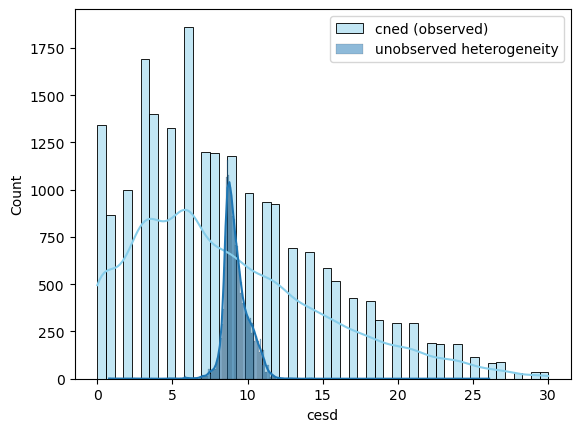

In [11]:
Xpred = X
Xpred['child']=0
Xpred['hrsusu']=0
Xpred['hsize']=0
Xpred['retired']=0
Xpred['wealth']=0
yhat = cre.predict(Xpred)

sns.histplot(data=y, color="skyblue", label="cned (observed)", kde=True)
sns.histplot(data=yhat, color="red", label="unobserved heterogeneity", kde=True)

plt.legend() 
plt.show()

In [14]:
print(lmp.compare({"FE": fe, "RE": re, "CRE": cre}))

                             Model Comparison                            
                                   FE                RE               CRE
-------------------------------------------------------------------------
Dep. Variable                    cesd              cesd              cesd
Estimator                    PanelOLS     RandomEffects     RandomEffects
No. Observations                21045             21045             21045
Cov. Est.                      Robust            Robust            Robust
R-squared                      0.0009            0.0272            0.0324
R-Squared (Within)             0.0009           -0.0037            0.0009
R-Squared (Between)            0.0051            0.0246            0.0298
R-Squared (Overall)            0.0040            0.0182            0.0250
F-statistic                    2.1217            117.70            70.508
P-value (F-stat)               0.0598            0.0000            0.0000
=====================     =========== 

<font size="3">**Tarea 2**</font>

<u> *Instrucciones* </u>

Los resultados de los ejericicios propuestos se deben entregar como un notebook por correo electronico a *juancaros@udec.cl* el dia 9/5 hasta las 21:00. 

Es importante considerar que el código debe poder ejecutarse en cualquier computadora con la data original del repositorio. Recordar la convencion para el nombre de archivo ademas de incluir en su documento titulos y encabezados por seccion. La data a utilizar es **enia.csv**.

Las variables tienen la siguiente descripcion:

- *ID*: firm unique identifier  
- *year*: survey year  
- *tamano*: 1 large, 2 medium, 3 small, 4 micro (funcion de las ventas y el numero de trabajadores)  
- *sales*: sales (in log of 1,000 CLP)  
- *age*: firm age at time of survey  
- *foreign*: non-domestic firm (binary)  
- *export*: production for export (binary)  
- *workers*: log of number of workers  
- *fomento*: firm receives public incentives (binary)  
- *iyd*: firm does I+D (binary)  
- *impuestos*: taxes (in million US)  
- *utilidades*: firm revenue (in million US)  

Para este analisis consideraremos tamaño como una variable continua, que identifica el tamaño de la empresa.

Preguntas:

1. Cargar la base de datos *enia.csv* en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario. Para las preguntas 2-8 **EXCLUYA LA VARIABLE FOMENTO DE SU ANALISIS**.

**R:** El panel cuenta con 10,213 observaciones en el primer periodo, cayendo a 6,480. Sin embargo, existen 24,130 ID unicos de empresa, lo que implica que existe una cantidad importante de empresas que han entrado al panel en periodos subsiguientes para mantener el numero total. Las empresas en el panel tienen importante variacion en el total de ventas, edad y numero de trabajadores. Un 8% de las empresas son extranjeras, 11% exporta y 22% hace alguna actividad de IyD.

In [2]:
enia=pd.read_csv('../data/enia.csv')
enia.dropna(inplace=True)
enia.export = enia.export.astype(int)
Xa = enia
bycount = enia['year'].groupby(enia['year']).count()
bIDcount = enia['ID'].groupby(enia['ID']).count()
enia['yr'] = enia['year'].astype(object)
enia = pd.get_dummies(enia)
enia = enia.set_index(["ID","year"])
enia['utilidades']=np.log(enia['utilidades']-enia['utilidades'].min()+0.1)
enia = enia[enia["utilidades"] < 10000]
enia.describe()

C:\Users\juanc\AppData\Local\Temp\ipykernel_4208\38379287.py:8: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  enia = pd.get_dummies(enia)


,tamano,sales,age,foreign,export,workers,fomento,iyd,impuestos,utilidades,yr_2007,yr_2009,yr_2013,yr_2015,yr_2017
count,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000,39104.000000
mean,2.248773,3.574172,15.305084,0.081859,0.111191,1.757726,0.076105,0.224887,0.203856,5.500845,0.261124,0.180595,0.185838,0.206731,0.165712
std,1.153089,1.692742,12.488330,0.274153,0.314372,1.186507,0.265169,0.417514,15.869466,0.060706,0.439253,0.384687,0.388981,0.404966,0.371827
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-180.992528,-2.302585,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.337643,7.000000,0.000000,0.000000,0.778151,0.000000,0.000000,0.000000,5.499092,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,3.553321,14.000000,0.000000,0.000000,1.785330,0.000000,0.000000,0.000007,5.499092,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,4.539098,20.000000,0.000000,0.000000,2.661813,0.000000,0.000000,0.000167,5.499097,1.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,10.309005,190.000000,1.000000,1.000000,5.845915,1.000000,1.000000,2981.494528,10.729529,1.000000,1.000000,1.000000,1.000000,1.000000



2. Ejecute un modelo Pooled OLS para explicar el numero de trabajadores. Seleccione las variables independientes a incluir en el modelo final e interprete su significado. 

**R:** Segun el modelo inicial, todas las variables son significativas para explicar el numero de trabajadores excepto los impuestos, la cual es excluida en lo que continua. Los resultados muestran una correlacion positiva entre todos los factores excepto las utilidades. En particular, empresas que exportan, y aquellas que son extrajeras, tienen un numero de trabajadores promedio mayor.

In [3]:
y=enia['workers']
X=enia[['sales','age','foreign','export','iyd','utilidades','yr_2009','yr_2013','yr_2015','yr_2017']]
X=sm.add_constant(X)
model = lmp.PanelOLS(y, X)
mco = model.fit()
print(mco)

                          PanelOLS Estimation Summary                           
Dep. Variable:                workers   R-squared:                        0.6173
Estimator:                   PanelOLS   R-squared (Between):              0.6323
No. Observations:               39104   R-squared (Within):               0.4109
Date:                Tue, May 23 2023   R-squared (Overall):              0.6173
Time:                        14:30:52   Log-likelihood                -4.339e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6306.1
Entities:                       24128   P-value                           0.0000
Avg Obs:                       1.6207   Distribution:                F(10,39093)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             6306.1
                            


3. Ejecute un modelo de efectos fijos para explicar el numero de trabajadores.  Seleccione las variables independientes a incluir en el modelo final e interprete su significado. 

**R:** El modelo de efectos fijos muestra que las ventas y la actividad de IyD tiene un efecto positivo en el numero de trabajadores (al igual que si la empresa es extranjera), mientras que las utilidades, antiguedad y capacidad de exportar no son significativas. Es importnante recordar que el modelo FE considera la variacion de las empresas en el tiempo, y por tanto remueve la hetereogeneidad no observada que es fija y puede causar sesgo en OLS. 

In [4]:
model=lmp.PanelOLS(y,X, entity_effects=True)
fe=model.fit(cov_type="robust")
print(fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                workers   R-squared:                        0.5559
Estimator:                   PanelOLS   R-squared (Between):              0.4194
No. Observations:               39104   R-squared (Within):               0.5559
Date:                Tue, May 23 2023   R-squared (Overall):              0.4233
Time:                        14:31:04   Log-likelihood                   -3479.8
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1873.0
Entities:                       24128   P-value                           0.0000
Avg Obs:                       1.6207   Distribution:                F(10,14966)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             892.28
                            


4. Ejecute un modelo de efectos aleatorios para explicar el numero de trabajadores. Seleccione las variables independientes a incluir en el modelo final e interprete su significado. 

**R:** Los resultados del modelo de efectos aleatorios es comparable a OLS, sin embargo la magnitud es significativamente diferente. Es importante que, al igual que en FE, las diferencias con OLS tambien pueden estar asociadas a la existencia de muchas empresas con una sola observacion (puntos adicionales para realizar el analisis completo excluyendo las empresas que tienen solo una observacion).

In [5]:
model=lmp.RandomEffects(y,X)
re=model.fit(cov_type="robust")
print(re)

                        RandomEffects Estimation Summary                        
Dep. Variable:                workers   R-squared:                        0.5343
Estimator:              RandomEffects   R-squared (Between):              0.6196
No. Observations:               39104   R-squared (Within):               0.4798
Date:                Tue, May 23 2023   R-squared (Overall):              0.6036
Time:                        14:31:13   Log-likelihood                -2.422e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4485.9
Entities:                       24128   P-value                           0.0000
Avg Obs:                       1.6207   Distribution:                F(10,39093)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             4874.1
                            


5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

**R:** Los resultados entre modelos son sustancialmente diferentes, y en base al resultado del test de Hausman, se favorece el modelo de efectos fijos. Dado aquello, las utilidades y capacidad de exportacion son irrelevantes, pero los otros aspectos de la empresa son importantes respecto del numero de trabajadores; estos aumentan con las ventas, IyD, y si es extranjera. En otras palabras, empresas que hacen investigacion y aquellas de gran tamano (en ventas) son mas intensivas en numero de trabajadores, todo lo demas constante.

In [8]:
import numpy.linalg as la
from scipy import stats

def hausman(fe, re):
 diff = fe.params-re.params
 psi = fe.cov - re.cov
 dof = diff.size -1
 W = diff.dot(la.inv(psi)).dot(diff)
 pval = stats.chi2.sf(W, dof)
 return W, dof, pval

htest = hausman(fe, re) 
print("Hausman Test: chi-2 = {0}, df = {1}, p-value = {2}".format(htest[0], htest[1], htest[2]))

Hausman Test: chi-2 = 816.8930431782032, df = 10, p-value = 4.8141832456423486e-169


In [6]:
print(lmp.compare({"FE": fe, "RE": re, "Pooled": mco}))

                           Model Comparison                           
                                   FE                RE         Pooled
----------------------------------------------------------------------
Dep. Variable                 workers           workers        workers
Estimator                    PanelOLS     RandomEffects       PanelOLS
No. Observations                39104             39104          39104
Cov. Est.                      Robust            Robust     Unadjusted
R-squared                      0.5559            0.5343         0.6173
R-Squared (Within)             0.5559            0.4798         0.4109
R-Squared (Between)            0.4194            0.6196         0.6323
R-Squared (Overall)            0.4233            0.6036         0.6173
F-statistic                    1873.0            4485.9         6306.1
P-value (F-stat)               0.0000            0.0000         0.0000
=====================     ===========   ===============   ============
const 


6. Ejecute un modelo de efectos aleatorios correlacionados (CRE) para explicar el numero de trabajadores. Seleccione las variables independientes a incluir en el modelo final e interprete su significado. Es este modelo adecuado, dada la data disponible, para modelar el componente no observado?

**R:** El modelo CRE entrega resultados similares a FE, sin embargo la antiguedad de la empresa ahora es significativa, y el impacto de las ventas es mayor. Todas las variables incluidas para modelar el componente de heterogeneidad no observada son significativos tambien, lo cual es beneficioso para el ajuste del modelo.

In [7]:
X = enia.drop(['workers','tamano','fomento','yr_2009','yr_2013','yr_2015','yr_2017'], axis=1, inplace=False)
Xm = X.groupby(by = 'ID').transform('mean')
Xm.columns = ['m{}'.format(column) for column in Xm.columns]
Xc = pd.merge(enia,Xm, left_index=True, right_index=True)
Y = Xc['workers']
X = Xc[['sales','age','foreign','export','iyd','utilidades','msales','mage','mexport','miyd','mutilidades','yr_2009','yr_2013','yr_2015','yr_2017']]
X=sm.add_constant(X)

model=lmp.RandomEffects(y,X)
cre=model.fit(cov_type="robust")
print(cre)

                        RandomEffects Estimation Summary                        
Dep. Variable:                workers   R-squared:                        0.5622
Estimator:              RandomEffects   R-squared (Between):              0.6252
No. Observations:               39104   R-squared (Within):               0.5420
Date:                Tue, May 23 2023   R-squared (Overall):              0.6229
Time:                        14:31:32   Log-likelihood                -2.301e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3345.9
Entities:                       24128   P-value                           0.0000
Avg Obs:                       1.6207   Distribution:                F(15,39088)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             4340.1
                            


7. Usando el modelo CRE, prediga la distribucion del componente no observado. Que puede inferir respecto de la heterogeneidad fija en el tiempo y su impacto en el numero de trabajadores? 

**R:** La heterogeneidad no observada que se predice del modelo CRE tiene un comportamiento normal, lo cual en principio puede ser inapropiado dado que genera valores negativos en el log-workers, lo cual no deberia ocurrir. Sin embargo, en promedio captura una parte importante de la variacion de las empresas en cuanto a su numero de trabajadores.

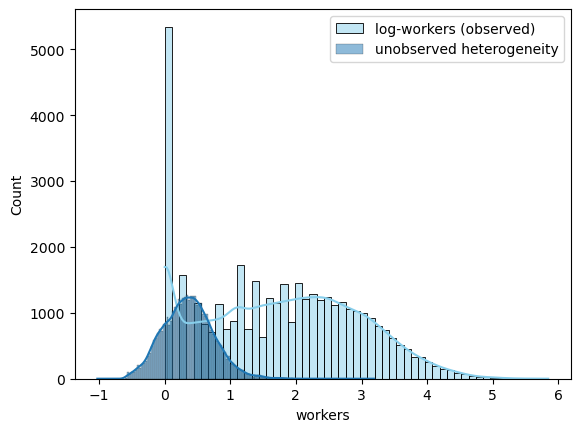

In [9]:
Xpred = X
Xpred['sales']=0
Xpred['age']=0
Xpred['export']=0
Xpred['iyd']=0
Xpred['utilidades']=0
Xpred['foreign']=0
Xpred['yr_2009']=0
Xpred['yr_2013']=0
Xpred['yr_2015']=0
Xpred['yr_2017']=0
yhat = cre.predict(Xpred)

sns.histplot(data=y, color="skyblue", label="log-workers (observed)", kde=True)
sns.histplot(data=yhat, color="red", label="unobserved heterogeneity", kde=True)

plt.legend() 
plt.show()

8. Usando sus respuestas anteriores, que modelo prefiere? que se puede inferir en general respecto del efecto de las variables explicativas sobre el numero de trabajadores?

**R:** En vista de los resultados, el ajuste y los coeficientes entregados, se favorece el modelo CRE, siendo este mas preciso que FE y RE, ademas de entregar diferencias importantes en coeficientes que podrian haber estado potencialmente sesgados (como ventas).

In [11]:
print(lmp.compare({"FE": fe, "RE": re, "CRE": cre}))

                             Model Comparison                            
                                   FE                RE               CRE
-------------------------------------------------------------------------
Dep. Variable                 workers           workers           workers
Estimator                    PanelOLS     RandomEffects     RandomEffects
No. Observations                39104             39104             39104
Cov. Est.                      Robust            Robust            Robust
R-squared                      0.5559            0.5343            0.5622
R-Squared (Within)             0.5559            0.4798            0.5420
R-Squared (Between)            0.4194            0.6196            0.6252
R-Squared (Overall)            0.4233            0.6036            0.6229
F-statistic                    1873.0            4485.9            3345.9
P-value (F-stat)               0.0000            0.0000            0.0000
=====================     =========== 


9. Considere que la variable *fomento* es una politica publica donde aleatoriamente se selecciono un grupo de empresas para recibir recursos financieros dedicados a incentivar I+D. Utilizando fomento como instrumento, estime un modelo en dos etapas para entender el impacto causal de la inversion en I+D sobre el numero de trabajadores, y compare versus el modelo MCO (puntos adicionales para hacerlo en un contexto de panel).

**R:** Al comparar los modelos se observa que la relacion entre IyD y numero de trabajadores esta sobre-estimada al usar MCO, mientras que al utilizar el instrumento, la relacion entre las variables baja sustancialmente. Lo que se puede inferir es que aquellas empresas que realizan IyD producto de la politica publica, contratan 12% mas trabajadores respecto de aquellas que no lo hacen, y no 30% como sugiere los resultados de MCO (potencial endogeneidad ya que pueden existir otros factores que inducen un incremento en el potencial de IyD y el numero de trabajadores, como el rubro de la empresa, por ejemplo).

In [11]:
from statsmodels.api import add_constant
#enia = sm.add_constant(enia)
res_ols = IV2SLS(enia.workers, enia[['sales','foreign','age','export','utilidades','iyd','const']], None, None).fit(
    cov_type="unadjusted")
res_IV = IV2SLS(enia.workers, enia[['sales','foreign','age','export','utilidades','const']], enia['iyd'], enia['fomento']).fit(
    cov_type="unadjusted")

from linearmodels.iv import compare
print(compare({"OLS": res_ols, "2SLS": res_IV}))

                 Model Comparison                 
                                OLS           2SLS
--------------------------------------------------
Dep. Variable               workers        workers
Estimator                       OLS        IV-2SLS
No. Observations              39104          39104
Cov. Est.                unadjusted     unadjusted
R-squared                    0.2498         0.2458
Adj. R-squared               0.2497         0.2457
F-statistic               1.302e+04      1.236e+04
P-value (F-stat)             0.0000         0.0000
==================     ============   ============
sales                        0.2485         0.2505
                           (78.177)       (75.422)
age                          0.0203         0.0206
                           (48.170)       (46.281)
export                       0.4179         0.4549
                           (24.237)       (18.788)
utilidades                  -0.4655        -0.4442
                          (-5.4